__David Sivieri__  
__CSC8200 Health Informatics & EHealth Systems__  
__Final Project__

# Project Description and Goal

Predicting which patients will be readmitted to a hospital within 30 days has become a priority in the medical community.  The goal of this project is to examine a dataset of diabetic patient encounters and attempt to use machine learning algorithms to predict which patients will be readmitted.

# Dataset Description

The dataset in use was sourced from the Health Facts database (Cerner Corporation, Kansas City, MO.)  This is a warehouse of clinical records from hospitals in the United States. The data comes from the hospital's electronic medical records database and has these characteristics:  

- Represents 10 years (1999 - 2008)
- 130 U.S. hospitals used
- Bed size of most hospital: 100 - 499 beds
- Entire raw database has 74,036,643 unique encounters
- Entire raw database has 17,880,231 unique patients
- Entire raw database has 2,889,571 providers

The database actually in use for this study was extracted from the above larger database based on these criteria:  

- Inpatient encounter
- Some form of diabetes was entered as a the diagnosis
- Length of stay - 1 to 14 days
- Lab tests were performed
- Medications were given

Final database has 101,766 encounters and 71,518 unique patients

# The code block below contains dependencies needed for the project:

In [1]:
import re
import math
import sys
import numpy as np
import pandas as pd

from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from sklearn.model_selection import RepeatedKFold
import scipy
import sklearn

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.max_rows", 1000000)
pd.set_option("display.max_columns", 1000000)
pd.set_option("display.width", 1000000)
pd.set_option("display.max_colwidth", 1000000)
pd.set_option("display.max_info_columns", 1000)
np.set_printoptions(threshold=sys.maxsize)

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

#import qgrid

In [2]:
%%HTML
<style type="text/css">
    table.dataframe td, table.dataframe th {
        border-style: solid;
        border: 1px solid lightgray;
    }
    tr:nth-child(even) {
        background: #eee;
    }
    th {
       background-color: lemonchiffon;
       color: black;
}
</style>

# This block is used to load the dataset and it performs some pre-processing:

In [3]:
# df = pd.read_csv("diabetic_data.csv", header=0, index_col=["patient_nbr", "encounter_id"])

# df["readmitted_less_30"] = (df.readmitted == "<30").astype('int')

# for col_name in df.select_dtypes(include="int64").columns:
#     df[col_name] = pd.to_numeric(df[col_name], downcast="integer")

# left_age = df.age.str.extract(pat=r"^\[([0-9]+)").astype("int")
# right_age = df.age.str.extract(pat=r"([0-9]+)\)$").astype("int")

# df["imputed_age"] = (right_age - left_age) / 2 + left_age
# df["imputed_age"] = pd.to_numeric(df["imputed_age"], downcast="integer")


# df.sort_values(by=["patient_nbr", "encounter_id"], inplace=True)

# df.to_pickle("diabetic_data.pkl")

# This block shows the first 5 lines of the dataset:

In [4]:
df = pd.read_pickle("diabetic_data.pkl")
df.head(5)

race  gender      age weight  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital payer_code                medical_specialty  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient diag_1 diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone change diabetesMed readmitted  readmitted_less_30  imputed_age
patient_nbr encounter_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
135         24437208      Caucasian  Female  [50-60)      ?                  2                         1                    1                 8          ?                       Cardiology                  77               6               33                  0                 0                 0    401    997    560                 8          None      None    Steady          No          No             No          No            No        No      Down          No           No            No       No       No           No         No      No          No  Steady                  No                  No                       No                      No                     No     Ch         Yes        <30                   1           55
            26264286      Caucasian  Female  [50-60)      ?                  1                         1                    7                 3          ?  Surgery-Cardiovascular/Thoracic                  31               1               14                  0                 0                 1    998     41    250                 5          None      None    Steady          No          No             No          No            No        No    Steady          No           No            No       No       No           No         No      No          No      No                  No                  No                       No                      No                     No     Ch         Yes        >30                   0           55
378         29758806      Caucasian  Female  [50-60)      ?                  3                         1                    1                 2          ?                    Surgery-Neuro                  49               1               11                  0                 0                 0    722    305    250                 3          None      None        No          No          No             No          No            No        No        No          No           No            No       No       No           No         No      No          No      No                  No                  No                       No                      No                     No     No          No         NO                   0           55
729         189899286     Caucasian  Female  [80-90)      ?                  1                         3                    7                 4         MC                 InternalMedicine                  68               2               23                  0                 0                 0    820    493   E880                 9       

# Partial table showing only core attributes

In [5]:
df_summary = df[["race", "gender", "age", "readmitted", "readmitted_less_30", "time_in_hospital", "number_inpatient", "number_outpatient", "number_emergency"]]

#qgrid.show_grid(df_summary.head(500), show_toolbar=True, grid_options={"forceFitColumns": False})
df_summary.head(15)

race  gender      age readmitted  readmitted_less_30  time_in_hospital  number_inpatient  number_outpatient  number_emergency
patient_nbr encounter_id                                                                                                                                          
135         24437208            Caucasian  Female  [50-60)        <30                   1                 8                 0                  0                 0
            26264286            Caucasian  Female  [50-60)        >30                   0                 3                 1                  0                 0
378         29758806            Caucasian  Female  [50-60)         NO                   0                 2                 0                  0                 0
729         189899286           Caucasian  Female  [80-90)         NO                   0                 4                 0                  0                 0
774         64331490            Caucasian  Female  [80-90)         NO                   0                 3                 0                  0                 0
927         14824206      AfricanAmerican  Female  [30-40)         NO                   0                 5                 0                  0                 0
1152        8380170       AfricanAmerican  Female  [50-60)        >30                   0                 6                 1                  0                 0
            30180318      AfricanAmerican  Female  [50-60)        >30                   0                 6                 2                  0                 0
            55533660      AfricanAmerican  Female  [60-70)        >30                   0                10                 1                  0                 0
            80742510      AfricanAmerican  Female  [60-70)        >30                   0                 8                 1                  0                 0
            83281464      AfricanAmerican  Female  [60-70)         NO                   0                12                 2                  0                 0
1305        66197028            Caucasian  Female  [60-70)         NO                   0                 9                 0                  0                 0
1314        60254142            Caucasian  Female  [40-50)        >30                   0                 2                 0                  0                 0
            70190028            Caucasian  Female  [40-50)        <30                   1                 1                 1                  0                 0
            70601076            Caucasian  Female  [40-50)         NO                   0                 3                 2                  0                 0

__With this code, I create a separate table that keeps only the first patient encounter per patient.  This allows me to analyze the demographics of the patient population accurately.__

In [6]:
# first_enc_df = df.number_inpatient.groupby(level=0, group_keys=False).nlargest(5)

first_enc_df = df.groupby(level=0).head(1)

first_enc_df.head(100)

print(len(df), len(first_enc_df))

101766 71518


# Core characteristic of numeric data:

The following table displays a statistical summary of the continuous columns of the database.  For example, the average age of the patient population is 65.97 years.  The average number of lab procedures is 43.10

In [7]:
continuous_cols = ["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses", "imputed_age"]
df[continuous_cols].describe().T.round(2).drop(["count"], axis=1)

,mean,std,min,25%,50%,75%,max
time_in_hospital,4.40,2.99,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,43.10,19.67,1.0,31.0,44.0,57.0,132.0
num_procedures,1.34,1.71,0.0,0.0,1.0,2.0,6.0
num_medications,16.02,8.13,1.0,10.0,15.0,20.0,81.0
number_outpatient,0.37,1.27,0.0,0.0,0.0,0.0,42.0
number_emergency,0.20,0.93,0.0,0.0,0.0,0.0,76.0
number_inpatient,0.64,1.26,0.0,0.0,0.0,1.0,21.0
number_diagnoses,7.42,1.93,1.0,6.0,8.0,9.0,16.0
imputed_age,65.97,15.94,5.0,55.0,65.0,75.0,95.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 101766 entries, (135, 24437208) to (189502619, 371459060)
Data columns (total 50 columns):
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int8
discharge_disposition_id    101766 non-null int8
admission_source_id         101766 non-null int8
time_in_hospital            101766 non-null int8
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int16
num_procedures              101766 non-null int8
num_medications             101766 non-null int8
number_outpatient           101766 non-null int8
number_emergency            101766 non-null int8
number_inpatient            101766 non-null int8
diag_1                      101766 non-null object
diag_2     

In [9]:
df_attrib = df.nunique().to_frame(name="Number of unique values")
df_attrib.index.names = ["ATTRIBUTE NAME"]
df_attrib

,Number of unique values
ATTRIBUTE NAME,
race,6
gender,3
age,10
weight,10
admission_type_id,8
discharge_disposition_id,26
admission_source_id,17
time_in_hospital,14
payer_code,18


In [10]:
def generate_val_cnts(input_df, col_header):
    df_temp = input_df.value_counts().to_frame(name="Count").join(input_df.value_counts(normalize=True).to_frame(name="Proportion"))
    df_temp.Proportion = (df_temp.Proportion * 100).map("{:.2f}%".format)
    df_temp.index.names = [col_header]
    return df_temp

In [11]:
df_readmit = generate_val_cnts(df.readmitted, "Readmitted in (days)")
df_readmit
# df_readmit.to_clipboard()

,Count,Proportion
Readmitted in (days),,
NO,54864,53.91%
>30,35545,34.93%
<30,11357,11.16%


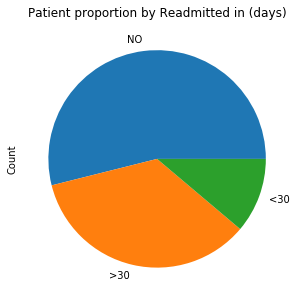

In [12]:
plot = df_readmit.Count.plot.pie(y="Race", figsize=(5, 5), title="Patient proportion by Readmitted in (days)")

In [13]:
df_race = generate_val_cnts(first_enc_df.race, "Race")
df_race
# df_race.to_clipboard()

,Count,Proportion
Race,,
Caucasian,53491,74.79%
AfricanAmerican,12887,18.02%
?,1948,2.72%
Hispanic,1517,2.12%
Other,1178,1.65%
Asian,497,0.69%


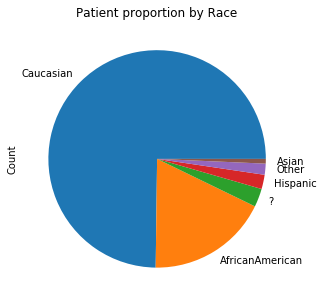

In [14]:
plot = df_race.Count.plot.pie(y="Race", figsize=(5, 5), title="Patient proportion by Race")

In [15]:
df_gender = generate_val_cnts(first_enc_df.gender, "Gender")
df_gender
# df_gender.to_clipboard()

,Count,Proportion
Gender,,
Female,38025,53.17%
Male,33490,46.83%
Unknown/Invalid,3,0.00%


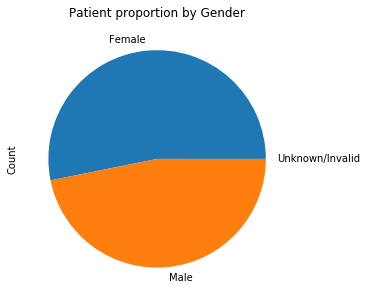

In [16]:
plot = df_gender.Count.plot.pie(y="Gender", figsize=(5, 5), title="Patient proportion by Gender")

In [17]:
df_age = generate_val_cnts(first_enc_df.age, "Age")
df_age.sort_values(by="Age")
# df_age.to_clipboard()

,Count,Proportion
Age,,
[0-10),154,0.22%
[10-20),535,0.75%
[20-30),1127,1.58%
[30-40),2699,3.77%
[40-50),6878,9.62%
[50-60),12466,17.43%
[60-70),15960,22.32%
[70-80),18210,25.46%
[80-90),11589,16.20%


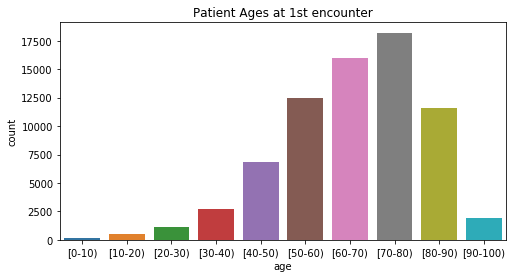

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(ax=ax, x="age", data=first_enc_df, order=sorted(first_enc_df.age.unique()))
ax.set_title("Patient Ages at 1st encounter")
plt.show()

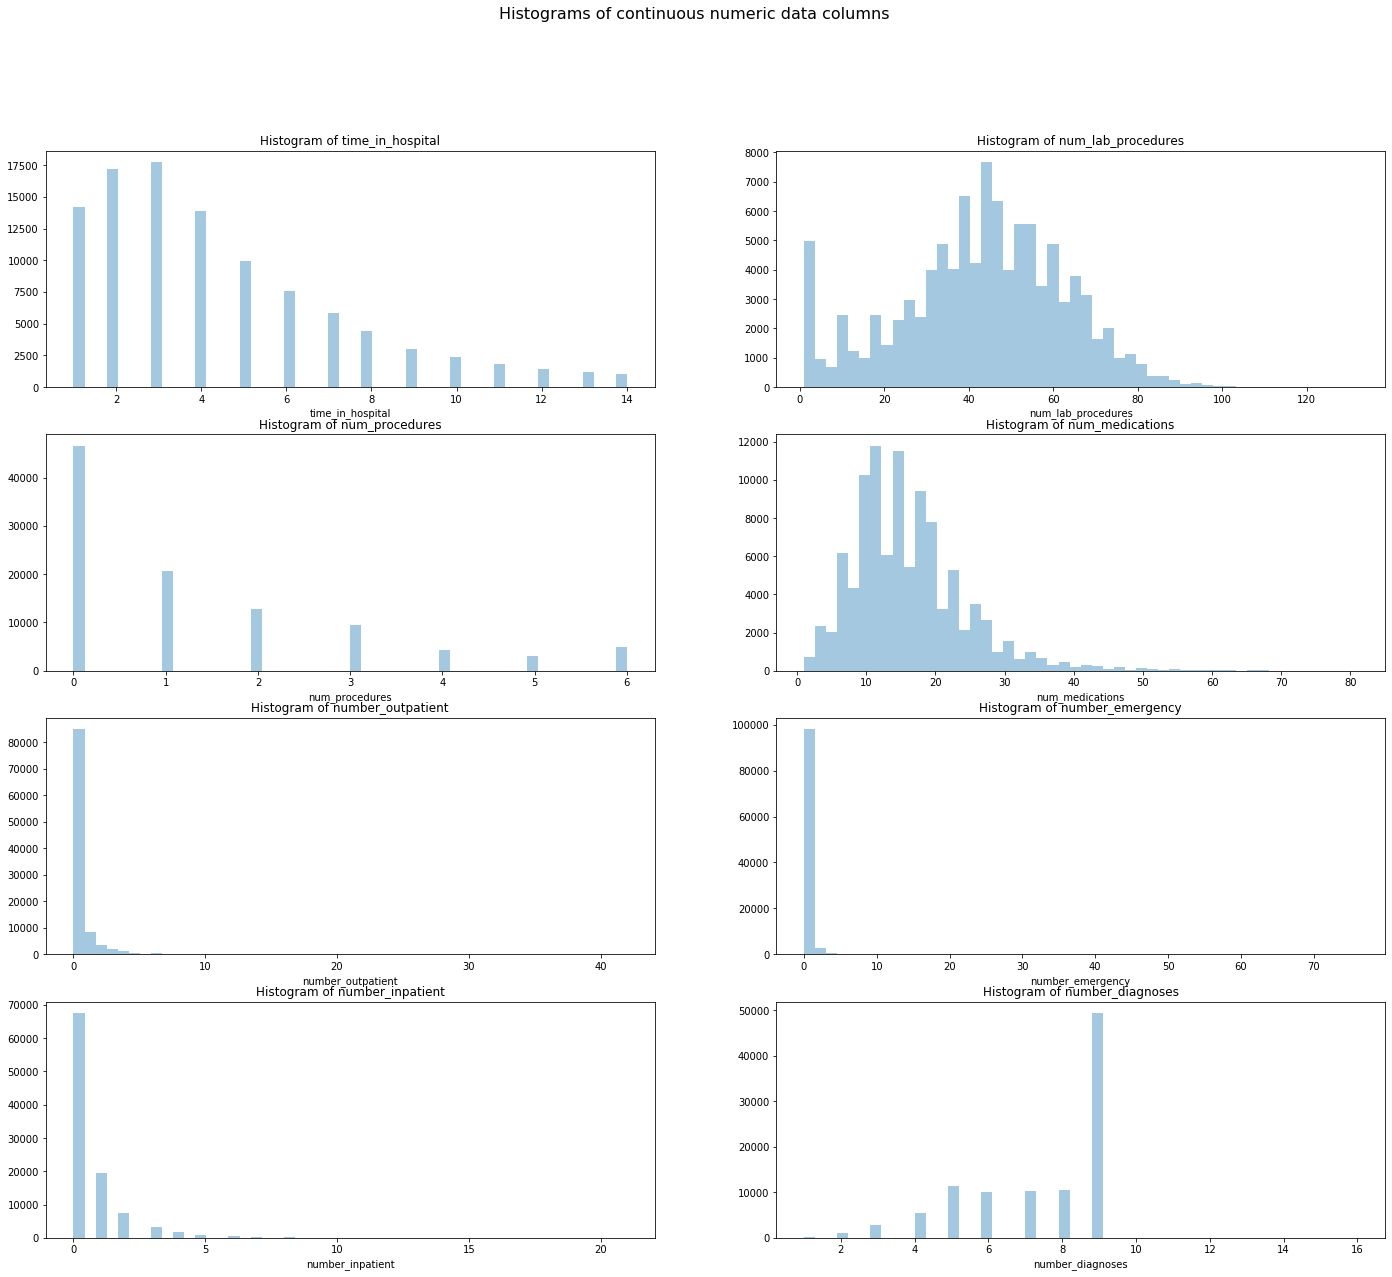

In [19]:
fig, axs = plt.subplots(4, 2, figsize=(24, 20))

for ax, col in zip(axs.flatten(), continuous_cols[:9]):
    sns.distplot(df[col], ax=ax, kde=False)
    ax.set_title(str("Histogram of " + col))
    
fig.suptitle('Histograms of continuous numeric data columns', fontsize=16)

plt.show()

In [20]:
comp_df = df.groupby("readmitted_less_30")[continuous_cols].mean()
comp_df.index = comp_df.index.map({0: "No", 1: "Yes"})
comp_df

ATTRIBUTE NAME,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,imputed_age
readmitted_less_30,,,,,,,,,
No,4.349224,42.953644,1.347123,15.911137,0.360871,0.177803,0.561648,7.388667,65.867392
Yes,4.768249,44.226028,1.280884,16.903143,0.436911,0.357313,1.224003,7.692789,66.760148


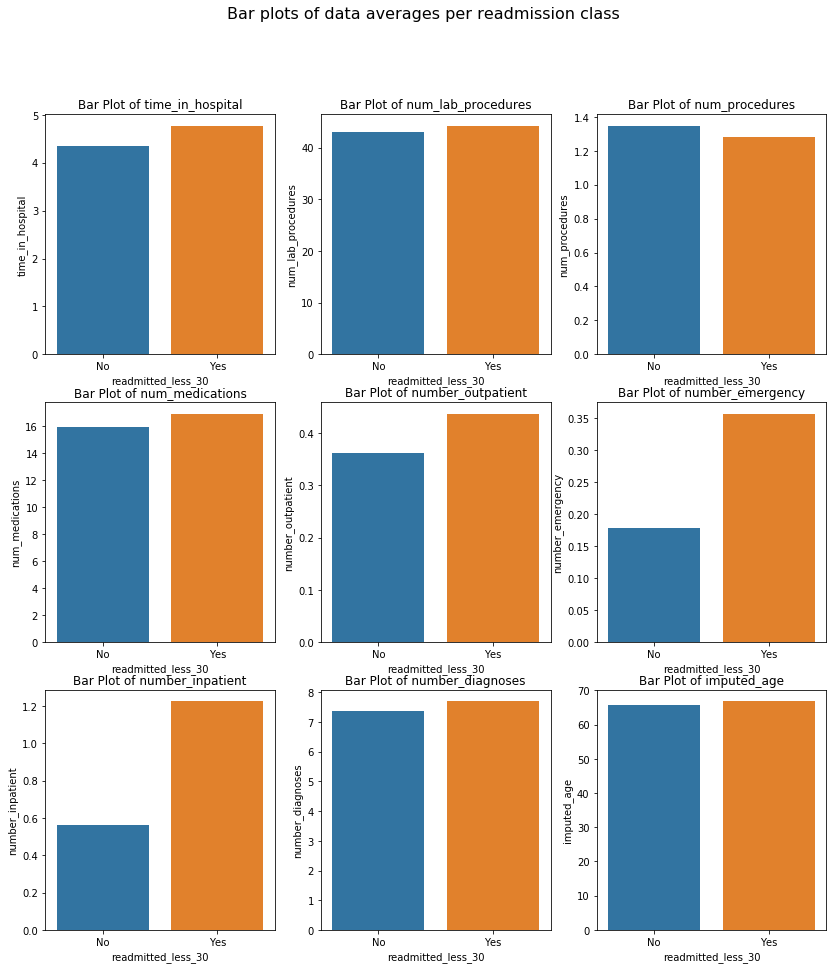

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(14, 15))

for ax, col in zip(axs.flatten(), comp_df.columns):
    sns.barplot(x=comp_df.index, y=col, ax=ax, data=comp_df)

    ax.set_title(str("Bar Plot of " + col))

fig.suptitle("Bar plots of data averages per readmission class", fontsize=16)

plt.show()

In [22]:
def gen_prop_df(col, df):
    temp_df = df.groupby(col).readmitted_less_30.sum() / df.groupby(col).readmitted_less_30.size()
    return temp_df.to_frame("Percentage readmitted within 30 days by class") * 100

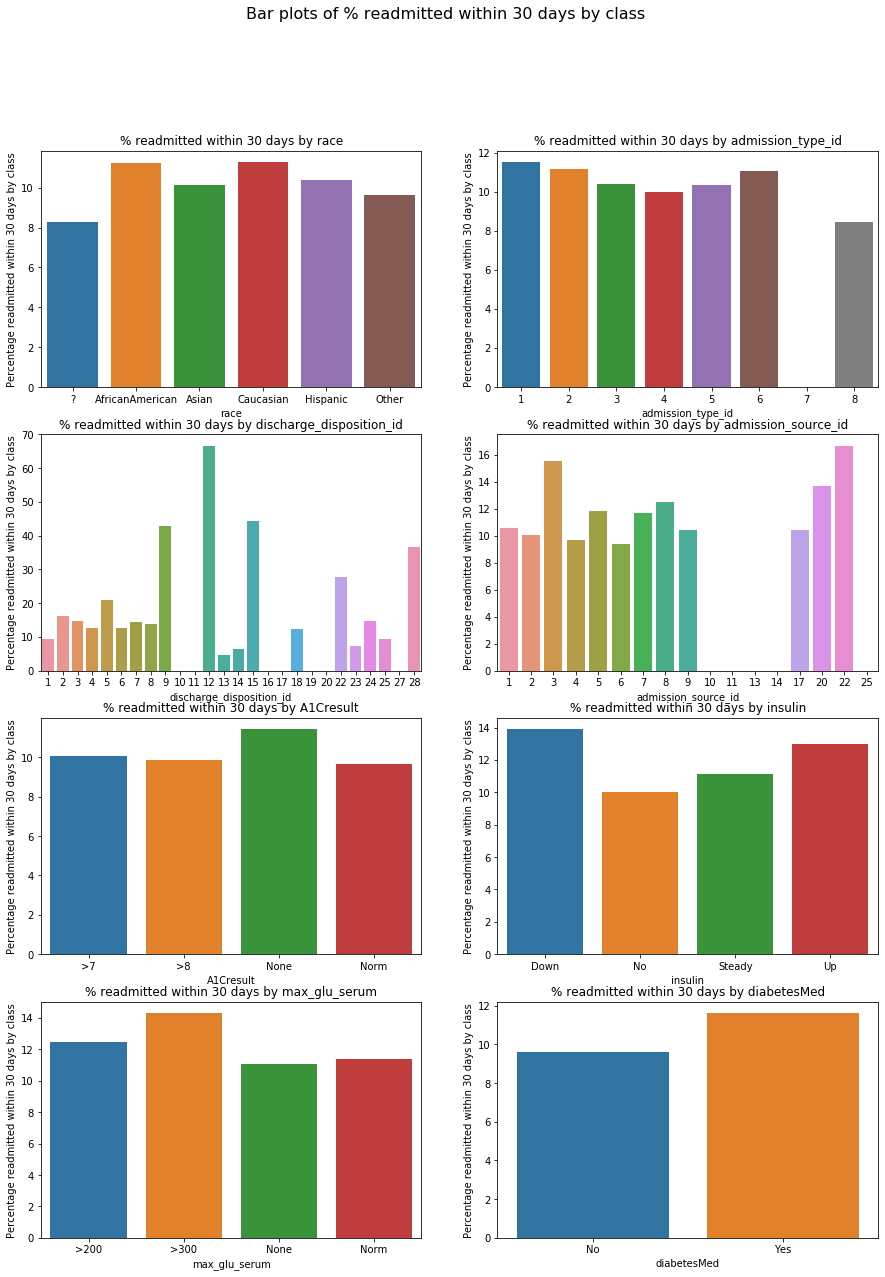

In [23]:
cols_to_test = ["race", "admission_type_id", "discharge_disposition_id", "admission_source_id", "A1Cresult", "insulin", "max_glu_serum", "diabetesMed"]


fig, axs = plt.subplots(4, 2, figsize=(15, 20))

for ax, col in zip(axs.flatten(), cols_to_test):

    temp_df = gen_prop_df(col, df)

    sns.barplot(x=temp_df.index, y=temp_df.columns[0], ax=ax, data=temp_df)

    ax.set_title(str("% readmitted within 30 days by " + col))

fig.suptitle("Bar plots of % readmitted within 30 days by class", fontsize=16)

plt.show()